In [ ]:
import os
import openai
import glob

from IPython.display import display, Code, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pymysql
import numpy as np
import pandas as pd
import json
import inspect
import re
#from bs4 import BeautifulSoup
import dateutil.parser as parser
import sys
sys.path.insert(0, '.\\functions\\untested functions')
sys.path.insert(0, '.\\functions\\tested functions')
from dotenv import load_dotenv

# 加载.env文件
load_dotenv()

#openai.api_key = os.getenv("OPENAI_API_KEY")
import warnings
warnings.filterwarnings("ignore")

from io import BytesIO

# 添加 OpenAI v1.0+ 的导入
from openai import OpenAI
client = OpenAI(
    api_key="4ffbb99a1e52e4184b5a54433c03a3bc9e643d84c779ffa396768ceb99a000da",
    base_url="https://uni-api.cstcloud.cn/v1"  # 注意：新版SDK推荐使用 base_url 而不是 api_base
)

def clean_json_string(text):
    """
    简洁版本：去除JSON代码块标记
    
    参数:
        text (str): 原始字符串
        
    返回:
        str: 清理后的字符串
    """
    # 去除开头的 ```json
    if text.startswith('```json'):
        text = text[7:]
    elif text.startswith('```'):
        text = text[3:]
    
    # 去除结尾的 ```
    if text.endswith('```'):
        text = text[:-3]
    
    return text.strip()


def run_conversation(messages, functions_list=None, model="deepseek-v3:671b"):
    """
    能够自动执行外部函数调用的Chat对话模型
    :param messages: 必要参数，字典类型，输入到Chat模型的messages参数对象
    :param functions_list: 可选参数，默认为None，可以设置为包含全部外部函数的列表对象
    :param model: Chat模型，可选参数，默认模型为gpt-4
    :return：Chat模型输出结果
    """
    # 如果没有外部函数库，则执行普通的对话任务
    if functions_list == None:
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        )
        response_message = response.choices[0].message
        final_response = response_message.content
        
    # 若存在外部函数库，则需要灵活选取外部函数并进行回答
    else:
        # 创建functions对象
        functions = auto_functions(functions_list)
        # 创建外部函数库字典
        available_functions = {func.__name__: func for func in functions_list}

        # first response
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        functions=functions,
                        function_call="auto")
        response_message = response.choices[0].message

        # 判断返回结果是否存在function_call，即判断是否需要调用外部函数来回答问题
        if response_message.function_call:
            # 需要调用外部函数
            # 获取函数名
            function_name = response_message.function_call.name
            # 获取函数对象
            fuction_to_call = available_functions[function_name]
            # 获取函数参数
            function_args = json.loads(response_message.function_call.arguments)
            # 将函数参数输入到函数中，获取函数计算结果
            function_response = fuction_to_call(**function_args)

            # messages中拼接first response消息
            messages.append(response_message)  
            # messages中拼接函数输出结果
            messages.append(
                {
                    "role": "function",
                    "name": function_name,
                    "content": function_response,
                }
            )  
            # 第二次调用模型
            second_response = client.chat.completions.create(
                model=model,
                messages=messages,
            )  
            # 获取最终结果
            final_response = second_response.choices[0].message.content
        else:
            final_response = response_message.content
    
    return final_response

def auto_functions(functions_list):
    """
    Chat模型的functions参数编写函数
    :param functions_list: 包含一个或者多个函数对象的列表；
    :return：满足Chat模型functions参数要求的functions对象
    """
    def functions_generate(functions_list):
        # 创建空列表，用于保存每个函数的描述字典
        functions = []
        
        def chen_ming_algorithm(data):
            """
            陈明算法函数，该函数定义了一种特殊的数据集计算过程
            :param data: 必要参数，表示带入计算的数据表，用字符串进行表示
            :return：陈明函数计算后的结果，返回结果为表示为JSON格式的Dataframe类型对象
            """
            df_new = pd.read_json(data)
            res = np.sum(df_new, axis=1) - 1
            return res.to_json(orient='records')
        
        chen_ming_function_description = inspect.getdoc(chen_ming_algorithm)
        
        chen_ming_function_name = chen_ming_algorithm.__name__
        
        chen_ming_function = {"name": "chen_ming_algorithm",
                              "description": "用于执行陈明算法的函数，定义了一种特殊的数据集计算过程",
                              "parameters": {"type": "object",
                                             "properties": {"data": {"type": "string",
                                                                     "description": "执行陈明算法的数据集"},
                                                           },
                                             "required": ["data"],
                                            },
                             }

        
        # 对每个外部函数进行循环
        for function in functions_list:
            # 读取函数对象的函数说明
            function_description = inspect.getdoc(function)
            # 读取函数的函数名字符串
            function_name = function.__name__

            user_message1 = '以下是某的函数说明：%s。' % chen_ming_function_description +\
                            '根据这个函数的函数说明，请帮我创建一个function对象，用于描述这个函数的基本情况。这个function对象是一个JSON格式的字典，\
                            这个字典有如下5点要求：\
                            1.字典总共有三个键值对；\
                            2.第一个键值对的Key是字符串name，value是该函数的名字：%s，也是字符串；\
                            3.第二个键值对的Key是字符串description，value是该函数的函数的功能说明，也是字符串；\
                            4.第三个键值对的Key是字符串parameters，value是一个JSON Schema对象，用于说明该函数的参数输入规范。\
                            5.输出结果必须是一个JSON格式的字典，只输出这个字典即可，前后不需要任何前后修饰或说明的语句' % chen_ming_function_name
            
            
            assistant_message1 = json.dumps(chen_ming_function)
            
            user_prompt = '现在有另一个函数，函数名为：%s；函数说明为：%s；\
                          请帮我仿造类似的格式为当前函数创建一个function对象。' % (function_name, function_description)

            response = client.chat.completions.create(
                              model="gpt-4o",
                              messages=[
                                {"role": "user", "content": user_message1},
                                {"role": "assistant", "content": assistant_message1},
                                {"role": "user", "content": user_prompt}]
                            )
            functions.append(json.loads(clean_json_string(response.choices[0].message.content)))
        return functions
    
    max_attempts = 3
    attempts = 0

    while attempts < max_attempts:
        try:
            functions = functions_generate(functions_list)
            break  # 如果代码成功执行，跳出循环
        except Exception as e:
            attempts += 1  # 增加尝试次数
            print("发生错误：", e)
            if attempts == max_attempts:
                print("已达到最大尝试次数，程序终止。")
                raise  # 重新引发最后一个异常
            else:
                print("正在重新运行...")
    return functions


In [3]:
messages = [
    {"role": "system", "content": "你好"},
    {"role": "user", "content": "请问user_demographics的第1条数据内容是？"}
]
from openai import OpenAI


# 正确示范：在初始化客户端时传入所有必要参数
client = OpenAI(
    api_key="4ffbb99a1e52e4184b5a54433c03a3bc9e643d84c779ffa396768ceb99a000da",
    base_url="https://uni-api.cstcloud.cn/v1"  # 注意：新版SDK推荐使用 base_url 而不是 api_base
)

# 调用时只需传入模型和消息等核心参数
response = client.chat.completions.create(
    model="deepseek-v3:671b",
    messages=messages,
)

# 打印结果
print(response.choices[0].message.content)



KeyboardInterrupt: 

In [75]:
import json
# 假设 client 已经正确初始化
# from openai import OpenAI
# client = OpenAI(api_key="...", base_url="...")
def extract_sql(json_str):
    # 解码JSON字符串
    data = json.loads(json_str)
    
    # 提取并返回'sql_query'的值
    return data.get('sql_query', None)
def check_code_run(messages, 
                   functions_list = None, 
                   functions = None, # 这个参数名保留，但它的内容会用于创建 tools
                   model = "deepseek-v3:671b", 
                   function_call = "auto", # 这个参数名保留，但会用于 tool_choice
                   auto_run = True):
    
    """
    能够自动执行外部函数调用的Chat对话模型，专门用于代码解释器的构建过程，可以通过auto_run参数设置，决定是否自动执行代码
    (已适配新版 OpenAI SDK v1.x)
    """
    
    # 如果没有外部函数库，则执行普通的对话任务
    if functions_list is None:
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        )
        # --- 修改点 1: 使用属性访问 ---
        response_message = response.choices[0].message
        final_response = response_message.content
        
    # 若存在外部函数库，则需要灵活选取外部函数并进行回答
    else:
        # 创建外部函数库字典
        available_functions = {func.__name__: func for func in functions_list}

        # --- 修改点 2: 新版 SDK 使用 tools 和 tool_choice ---
        # 将旧的 functions 列表转换为新的 tools 列表
        tools = [{"type": "function", "function": func_schema} for func_schema in functions]
        # 将旧的 function_call 参数映射到新的 tool_choice 参数
        tool_choice = function_call

        # first response
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        tools=tools,          # 使用 tools 替代 functions
                        tool_choice=tool_choice # 使用 tool_choice 替代 function_call
                        )
        # --- 修改点 3: 使用属性访问 ---
        response_message = response.choices[0].message

        # --- 修改点 4: 判断和访问工具调用 ---
        # 新版 SDK 中，function_call 信息在 tool_calls 属性中，它是一个列表
        if response_message.tool_calls:
            # 需要调用外部函数
            # 注意：一个响应可能包含多个 tool_calls，这里我们假设只有一个
            tool_call = response_message.tool_calls[0]
            function_name = tool_call.function.name
            fuction_to_call = available_functions[function_name]
            function_args = json.loads(tool_call.function.arguments)
            
            
                # 假设 extract_sql 函数存在
                # sql_query = extract_sql(tool_call.function.arguments)
                
            
            if 'sql_inter' in function_name or 'extract_data' in function_name:
                code =extract_sql(tool_call.function.arguments)
                # 将代码字符串转换为Markdown格式
                markdown_code = f"```sql\n{code}\n```"
            else:
                code = extract_python(tool_call.function.arguments)
                code = insert_fig_object(code)
                # 将代码字符串转换为Markdown格式
                markdown_code = f"```python\n{code}\n```"
                
            if auto_run == False:         
                print("已将问题转化为如下代码准备运行：")
                # 在Jupyter Notebook中展示Markdown格式的代码
                display(Markdown(markdown_code))
                
                res = input('即将执行以上代码，请确认是否执行（1），或者退出本次运行过程（2）')
                if res == '2':
                    print("终止运行")
                    return None
                else:
                    print("正在执行代码，请稍后...")
  
            # 将函数参数输入到函数中，获取函数计算结果
            function_response = fuction_to_call(**function_args)

            # messages中拼接first response消息
            messages.append(response_message)  
            # --- 修改点 5: 拼接工具调用结果 ---
            # 新版 SDK 中，工具调用的结果消息格式有所不同
            messages.append(
                {
                    "role": "tool",
                    "tool_call_id": tool_call.id, # 必须包含 tool_call_id
                    "name": function_name,
                    "content": str(function_response), # content 最好是字符串
                }
            )  
            # 第二次调用模型
            second_response = client.chat.completions.create(
                model=model,
                messages=messages,
            )  
            # --- 修改点 6: 使用属性访问获取最终结果 ---
            final_response = second_response.choices[0].message.content
        else:
            # 如果模型决定不调用任何工具，则直接返回内容
            final_response = response_message.content
            
    # 注意：删除 messages 可能会影响外部的调用逻辑，请确认是否需要
    # del messages
    
    return final_response



In [4]:
import tiktoken

# 使用cl100k_base编码，它适用于大多数现代大语言模型
encoding = tiktoken.get_encoding("cl100k_base")

# 或者您也可以使用encoding_for_model配合一个受支持的模型名称
# encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [71]:
def chat_with_inter(functions_list=None, 
                    prompt="你好呀", 
                    model="gpt-4o", 
                    system_message=[{"role": "system", "content": "你是一位乐于助人的助手。"}], 
                    auto_run = True):
    
    # 创建函数列表对应的参数解释列表
    functions = auto_functions(functions_list)
    
    # 多轮对话阈值
    if '4' in model:
        tokens_thr = 6000
    elif '16' in model:
        tokens_thr = 14000
    else:
        tokens_thr = 3000
    
    messages = system_message
    messages.append({"role": "user", "content": prompt})
    
    tokens_count = len(encoding.encode((prompt + system_message[0]["content"])))
    
    while True:           
        answer = check_code_run(messages, 
                                functions_list=functions_list, 
                                functions=functions, 
                                model=model, 
                                function_call="auto", 
                                auto_run = auto_run)
        
        if answer is None:
            answer = ""
        print(f"模型回答: {answer}")

        # 询问用户是否还有其他问题
        user_input = input("您还有其他问题吗？(输入退出以结束对话): ")
        if user_input == "退出":
            del messages
            break

        # 记录新一轮问答
        messages.append({"role": "assistant", "content": answer})
        messages.append({"role": "user", "content": user_input})
        
        # 计算当前总token数
        tokens_count += len(encoding.encode((answer + user_input)))
        
        # 删除超出token阈值的对话内容
        while tokens_count >= tokens_thr:
            tokens_count -= len(encoding.encode(messages.pop(1)["content"]))

In [6]:
def extract_function_code(s, detail=0, tested=False):
    """
    函数提取函数，同时执行函数内容，可以选择打印函数信息，并选择代码保存的地址
    """
    def extract_code(s):
        """
        如果输入的字符串s是一个包含Python代码的Markdown格式字符串，提取出代码部分。
        否则，返回原字符串。

        参数:
        s: 输入的字符串。

        返回:
        提取出的代码部分，或原字符串。
        """
        # 判断字符串是否是Markdown格式
        if '```python' in s or 'Python' in s or'PYTHON' in s:
            # 找到代码块的开始和结束位置
            code_start = s.find('def')
            code_end = s.find('```\n', code_start)
            # 提取代码部分
            code = s[code_start:code_end]
        else:
            # 如果字符串不是Markdown格式，返回原字符串
            code = s

        return code
    
    # 提取代码字符串
    code = extract_code(s)
    
    # 提取函数名称
    match = re.search(r'def (\w+)', code)
    function_name = match.group(1)
    
    # 将函数写入本地
    if tested == False:
        with open('./functions/untested functions/%s_module.py' % function_name, 'w', encoding='utf-8') as f:
            f.write(code)
    else:
        with open('./functions/tested functions/%s_module.py' % function_name, 'w', encoding='utf-8') as f:
            f.write(code)
    
    # 执行该函数
    try:
        exec(code, globals())
    except Exception as e:
        print("An error occurred while executing the code:")
        print(e)
    
    # 打印函数名称
    if detail == 0:
        print("The function name is:%s" % function_name)
    
    if detail == 1:
        with open('%s.py' % function_name, encoding='utf-8') as f:
            content = f.read()
        print(content)

In [7]:
def show_functions(tested=False):
    """
    打印tested或untested文件夹内全部函数
    """
    current_directory = os.getcwd()
    if tested == False:
        module_path = current_directory + '\\functions\\untested functions'
    else:
        module_path = current_directory + '\\functions\\tested functions'
        
    py_files = glob.glob(os.path.join(module_path, "*.py"))

    for file in py_files:
        print(file)

In [5]:
dataset = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('max_colwidth',200)

dataset.head(5)
from sklearn.model_selection import train_test_split

In [6]:
train_data, test_data = train_test_split(dataset, test_size=0.20, random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8,No
1,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45,No
2,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45,Yes
3,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95,Yes
4,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No


In [7]:
# 1. User Demographics
user_demographics_train = train_data[['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']]

# 2. User Services
user_services_train = train_data[['customerID', 'PhoneService', 'MultipleLines', 'InternetService',
                         'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                         'StreamingTV', 'StreamingMovies']]

# 3. User Payments
user_payments_train = train_data[['customerID', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']]

# 4. User Churn
user_churn_train = train_data[['customerID', 'Churn']]

In [8]:
# 1. User Demographics
user_demographics_test = test_data[['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']]

# 2. User Services
user_services_test = test_data[['customerID', 'PhoneService', 'MultipleLines', 'InternetService',
                         'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                         'StreamingTV', 'StreamingMovies']]

# 3. User Payments
user_payments_test = test_data[['customerID', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']]

# 4. User Churn
user_churn_test = test_data[['customerID', 'Churn']]

In [9]:
import numpy as np

# Random seed for reproducibility
np.random.seed(42)

# 1. Remove some rows from user_demographics
drop_indices = np.random.choice(user_demographics_train.index, size=int(0.05 * len(user_demographics_train)), replace=False)
user_demographics_train = user_demographics_train.drop(drop_indices)

# 2. Add some new customer IDs to user_services
new_ids = ["NEW" + str(i) for i in range(100)]
new_data_train = pd.DataFrame({'customerID': new_ids})
user_services_train = pd.concat([user_services_train, new_data_train], ignore_index=True)

# 3. Add missing values to user_payments
for _ in range(100):
    row_idx = np.random.randint(user_payments_train.shape[0])
    col_idx = np.random.randint(1, user_payments_train.shape[1])  # skipping customerID column
    user_payments_train.iat[row_idx, col_idx] = np.nan

# 4. Add new customer IDs to user_churn
new_ids_churn_train = ["NEWCHURN" + str(i) for i in range(50)]
new_data_churn_train = pd.DataFrame({'customerID': new_ids_churn_train, 'Churn': ['Yes'] * 25 + ['No'] * 25})
user_churn_train = pd.concat([user_churn_train, new_data_churn_train], ignore_index=True)

In [10]:
# 创建目标文件夹，如果它还不存在
if not os.path.exists('telco_data'):
    os.makedirs('telco_data')

# 保存 DataFrame 为 CSV 文件
user_demographics_train.to_csv('telco_data/user_demographics_train.csv', index=False)
user_services_train.to_csv('telco_data/user_services_train.csv', index=False)
user_payments_train.to_csv('telco_data/user_payments_train.csv', index=False)
user_churn_train.to_csv('telco_data/user_churn_train.csv', index=False)

user_demographics_test.to_csv('telco_data/user_demographics_test.csv', index=False)
user_services_test.to_csv('telco_data/user_services_test.csv', index=False)
user_payments_test.to_csv('telco_data/user_payments_test.csv', index=False)
user_churn_test.to_csv('telco_data/user_churn_test.csv', index=False)

In [ ]:
import pymysql
import decimal 

In [68]:
def insert_image_to_doc(folder_id, doc_name, figure, insert_to_doc=False):
    """
    上传图片至谷歌云盘，并可选是否将图片添加至某谷歌云文档中
    """
    creds = Credentials.from_authorized_user_file('token.json')
    drive_service = build('drive', 'v3', credentials=creds)
    docs_service = build('docs', 'v1', credentials=creds)
    
    # 1. Save image to Google Drive
    buf = BytesIO()
    figure.savefig(buf, format='png')
    buf.seek(0)
    media = MediaIoBaseUpload(buf, mimetype='image/png', resumable=True)
    file_metadata = {
        'name': 'YourImageName.png',
        'parents': [folder_id],
        'mimeType': 'image/png'
    }
    image_file = drive_service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id,webViewLink,webContentLink'  # Specify the fields to be returned
    ).execute()
    image_id = image_file['id']
    
    # Print the public URLs of the image file
    # print(f'View link: {image_file["webViewLink"]}')
    # print(f'Download link: {image_file["webContentLink"]}')
    
    # Set the image file to be publicly accessible
    permission = {
        'type': 'anyone',
        'role': 'reader',
    }
    permission_response = drive_service.permissions().create(fileId=image_id, body=permission).execute()
    
    
    # Check if the permission change was successful
    if not permission_response.get('id'):
        raise Exception('Failed to set the image file to be publicly accessible')

    # Wait for a short duration to ensure the permission change has propagated
    time.sleep(5)

    # 2. Insert image into Google Doc
    if insert_to_doc == True:
        document_id = append_or_create_doc_in_folder(folder_id, doc_name, "")  # Use your function to get document_id
        end_of_doc = docs_service.documents().get(documentId=document_id).execute()['body']['content'][-1]['endIndex'] - 1
        requests = [{
           'insertInlineImage': {
               'location': {'index': end_of_doc},
               'uri': f'https://drive.google.com/uc?id={image_id}',
               'objectSize': {
                   'height': {'magnitude': 50, 'unit': 'PT'},
                   'width': {'magnitude': 50, 'unit': 'PT'}
               }
           }
        }]
        docs_service.documents().batchUpdate(documentId=document_id, body={'requests': requests}).execute()
    
    return image_file["webContentLink"]
def extract_python(json_str):
    """
    解码JSON字符串中的Python代码
    """
    data = json.loads(json_str)
    
    # 提取并返回'sql_query'的值
    return data.get('py_code', None)
def insert_fig_object(code_str):
    """
    为绘图代码创建fig对象，以便于存储至谷歌云盘
    """
    global fig
    # 检查是否已存在 fig 对象的创建
    if 'fig = plt.figure' in code_str:
        return code_str  # 如果存在，则返回原始代码字符串

    # 定义可能的库别名和全名
    plot_aliases = ['plt.', 'matplotlib.pyplot.']
    sns_aliases = ['sns.', 'seaborn.']

    # 寻找第一次出现绘图相关代码的位置
    first_plot_occurrence = min((code_str.find(alias) for alias in plot_aliases + sns_aliases if code_str.find(alias) >= 0), default=-1)
 
    # 如果找到绘图代码，则在该位置之前插入 fig 对象的创建
    if first_plot_occurrence != -1:
        plt_figure_index = code_str.find('plt.figure')
        if plt_figure_index != -1:
            # 寻找 plt.figure 后的括号位置，以确定是否有参数
            closing_bracket_index = code_str.find(')', plt_figure_index)
            # 如果找到了 plt.figure()，则替换为 fig = plt.figure()
            modified_str = code_str[:plt_figure_index] + 'fig = ' + code_str[plt_figure_index:closing_bracket_index + 1] + code_str[closing_bracket_index + 1:]
        else:
            modified_str = code_str[:first_plot_occurrence] + 'fig = plt.figure()\n' + code_str[first_plot_occurrence:]
        return modified_str
    else:
        return code_str  # 如果没有找到绘图代码，则返回原始代码字符串
def extract_data(sql_query,df_name):
    """
    用于借助pymysql，将MySQL中的telco_db数据库中的表读取并保存到本地Python环境中。
    :param sql_query: 字符串形式的SQL查询语句，用于提取MySQL中telco_db数据库中的某张表。
    :param df_name: 将MySQL数据库中提取的表格进行本地保存时的变量名，以字符串形式表示。
    :return：表格读取和保存结果
    """
    
    mysql_pw = os.getenv('MYSQL_PW')
    
    connection = pymysql.connect(
            host='localhost',  # 数据库地址
            user='root',  # 数据库用户名
            passwd=mysql_pw,  # 数据库密码
            db='telco_db',  # 数据库名
            charset='utf8'  # 字符集选择utf8
        )
    
    
    globals()[df_name] = pd.read_sql(sql_query, connection)
    
    return "已成功完成%s变量创建" % df_name
def python_inter(py_code):
    """
    用于对telco_db数据库中各张数据表进行查询和处理，并获取最终查询或处理结果。
    :param py_code: 字符串形式的Python代码，用于执行对telco_db数据库中各张数据表进行操作
    :return：代码运行的最终结果
    """    
    # 添加图片对象，如果存在绘图代码，则创建fig对象
    py_code = insert_fig_object(py_code)
    global_vars_before = set(globals().keys())
    try:
        exec(py_code, globals())
    except Exception as e:
        return str(e)
    global_vars_after = set(globals().keys())
    new_vars = global_vars_after - global_vars_before
    if new_vars:
        result = {var: globals()[var] for var in new_vars}
        return str(result)
    else:
        try:
            return str(eval(py_code, globals()))
        except Exception as e:
            return "已经顺利执行代码"
def sql_inter(sql_query):
    """
    用于获取telco_db数据库中各张表的有关相关信息，\
    核心功能是将输入的SQL代码传输至telco_db数据库所在的MySQL环境中进行运行，\
    并最终返回SQL代码运行结果。需要注意的是，本函数是借助pymysql来连接MySQL数据库。
    :param sql_query: 字符串形式的SQL查询语句，用于执行对MySQL中telco_db数据库中各张表进行查询，并获得各表中的各类相关信息
    :return：sql_query在MySQL中的运行结果。
    """
    
    mysql_pw = os.getenv('MYSQL_PW')
    
    connection = pymysql.connect(
            host='localhost',  # 数据库地址
            user='root',  # 数据库用户名
            passwd=mysql_pw,  # 数据库密码
            db='telco_db',  # 数据库名
            charset='utf8'  # 字符集选择utf8
        )
    
    try:
        with connection.cursor() as cursor:
            # SQL查询语句
            sql = sql_query
            cursor.execute(sql)

            # 获取查询结果
            results = cursor.fetchall()
            
            # 处理Decimal类型，使其可以被JSON序列化
            processed_results = []
            for row in results:
                processed_row = []
                for item in row:
                    if isinstance(item, decimal.Decimal):
                        processed_row.append(float(item))
                    else:
                        processed_row.append(item)
                processed_results.append(processed_row)

    finally:
        connection.close()

    return json.dumps(processed_results)

In [9]:
# 打开并读取Markdown文件
with open('telco_data_dictionary_new.md', 'r', encoding='utf-8') as f:
    md_content = f.read()
#encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
#len(encoding.encode(md_content))

In [67]:
functions_list = [extract_data]
functions =auto_functions(functions_list)
functions

[{'name': 'extract_data',
  'description': '用于借助pymysql，将MySQL中telco_db数据库中的表读取并保存到本地Python环境中',
  'parameters': {'type': 'object',
   'properties': {'sql_query': {'type': 'string',
     'description': '字符串形式的SQL查询语句'},
    'df_name': {'type': 'string',
     'description': '将MySQL数据库中提取的表格进行本地保存时的变量名'}},
   'required': ['sql_query', 'df_name']}}]

In [ ]:
functions_list = [sql_inter]
functions =auto_functions(functions_list)


[{'name': 'sql_inter',
  'description': '用于获取telco_db数据库中各张表的有关相关信息，核心功能是将输入的SQL代码传输至telco_db数据库所在的MySQL环境中进行运行，并最终返回SQL代码运行结果',
  'parameters': {'type': 'object',
   'properties': {'sql_query': {'type': 'string',
     'description': 'SQL查询语句，用于执行对MySQL中telco_db数据库中各张表进行查询'}},
   'required': ['sql_query']}}]

In [44]:
functions

[{'name': 'sql_inter',
  'description': '用于获取telco_db数据库中各张表的有关相关信息，核心功能是将输入的SQL代码传输至telco_db数据库所在的MySQL环境中进行运行，并最终返回SQL代码运行结果',
  'parameters': {'type': 'object',
   'properties': {'sql_query': {'type': 'string',
     'description': 'SQL查询语句，用于执行对MySQL中telco_db数据库中各张表进行查询'}},
   'required': ['sql_query']}}]

In [ ]:
model="deepseek-v3:671b"
chat_with_inter(functions_list=functions_list, 
                prompt="我想根据telco_db数据库中数据分析用户流失情况，请问需要用到telco_db数据库中的那几张表呢？", 
                model=model, 
                system_message=[{"role": "system", "content": md_content}], 
                auto_run = False)

模型回答: 为了分析用户流失情况，你需要用到 `telco_db` 数据库中的以下两张表：

1. **user_demographics（用户基本信息表）**  
   - 包含了用户的性别、年龄、婚姻状况等基本信息，可以用来分析用户流失是否与这些基础属性相关。

2. **user_services（用户订阅服务表）**  
   - 包含了用户订购的电话、网络、增值服务（如网络安全、网络电视等）信息，可以用来分析用户流失是否与服务的多样性或满意度相关。

3. **user_payments（用户支付信息表）**  
   - 包含了支付方式、合同类型、月付金额等信息，可以用来分析用户流失是否与支付习惯或合同类型相关。

4. **user_churn（用户流失标记表）**  
   - 直接记录了用户是否流失（Churn字段），是分析的核心目标表。

### 重点字段分析：
- **关联键**：所有表通过 `customerID` 字段关联。
- **关键目标字段**：`user_churn` 表中的 `Churn` 字段（Yes/No）。
- **分析维度**：
  - 基础属性（性别、年龄、婚姻状况）
  - 服务类型（电话、网络、增值服务）
  - 支付行为（合同类型、费用、支付方式）

如果需要进一步查询或构建具体分析逻辑（如流失率统计、特征相关性分析），可以告诉我你的需求，我可以帮你编写SQL查询！
正在执行代码，请稍后...
模型回答: 在 `user_demographics` 表中，不同性别的用户占比分布如下：

| 性别（gender） | 用户数量（user_count） | 占比（percentage） |
|----------------|-----------------------|-------------------|
| Male（男性）   | 2,744                 | 51.26%            |
| Female（女性） | 2,609                 | 48.74%            |

### 说明：
1. **男性用户略多于女性**：男性占比51.26%，女性占比48.74%，性别分布相对均衡。
2. **数据无缺失值**：所有用户均标注了性别（总数=2,

In [58]:
model="deepseek-v3:671b"
response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": "查询user_payments数据表有的列"}],
        tools = [{"type": "function", "function": functions[0]}],
        tool_choice={"type": "function", "function": {"name": "sql_inter"}},  
    )
response.choices[0].message.tool_calls

[ChatCompletionMessageToolCall(id='chatcmpl-tool-02d6d820777142009ea2da35fe8eef71', function=Function(arguments='{"sql_query":"SHOW COLUMNS FROM user_payments;"}', name='sql_inter'), type='function')]

In [52]:
response.choices[0].message

ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=FunctionCall(arguments='{"sql_query":"SHOW COLUMNS FROM user_payments;"}', name='sql_inter'), tool_calls=None)

In [69]:
functions_list = [sql_inter, extract_data, python_inter]

正在执行代码，请稍后...
已将问题转化为如下代码准备运行：


```sql
SELECT * FROM user_demographics
```

正在执行代码，请稍后...
模型回答: user_demographics数据表已成功保存到本地Python环境中，并命名为`user_demographics_df`。
正在执行代码，请稍后...
已将问题转化为如下代码准备运行：


```python
import pandas as pd

# Read user_demographics data
df = user_demographics_df

# Check if 'customerID' values are unique
customerID_unique = df['customerID'].is_unique

# Check for missing values in remaining columns
missing_values = df[['gender', 'SeniorCitizen', 'Partner', 'Dependents']].isnull().sum()

customerID_unique, missing_values
```

正在执行代码，请稍后...
模型回答: 在 `user_demographics_df` 数据集中，`customerID` 是唯一的。此外，`gender`、`SeniorCitizen`、`Partner` 和 `Dependents` 属性中没有缺失值。
正在执行代码，请稍后...
已将问题转化为如下代码准备运行：


```python
import matplotlib.pyplot as plt

df = user_demographics_df

gender_counts = df['gender'].value_counts()

fig = plt.figure(figsize=(8, 6))
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()
```

正在执行代码，请稍后...


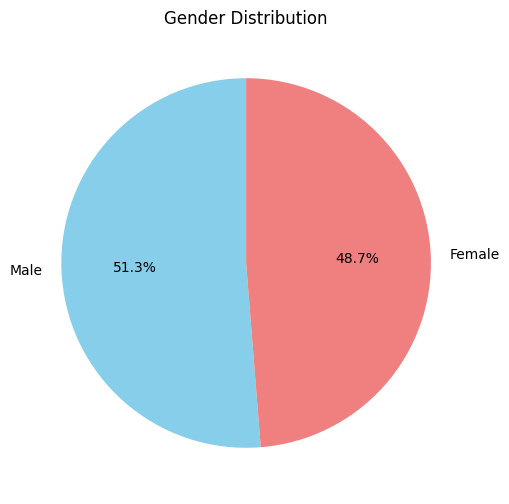

模型回答: 已成功生成性别分布情况的饼图。请查看图表以获取可视化结果。


In [74]:
chat_with_inter(functions_list=functions_list, 
                prompt="请将telco_db数据库中的user_demographics表保存到本地Python环境中，并命名为user_demographics_df", 
                model="gpt-4o", 
                system_message=[{"role": "system", "content": md_content}], 
                auto_run = False)